In [ ]:
#Importing all the files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

In [32]:
#Load the Dataset
data = pd.read_csv('/content/creditcard.csv')
data.rename(columns={'Class': 'is_fraud'}, inplace=True)
print(data.head())
print(data.info())
print("Class distribution:\n", data['is_fraud'].value_counts())



   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

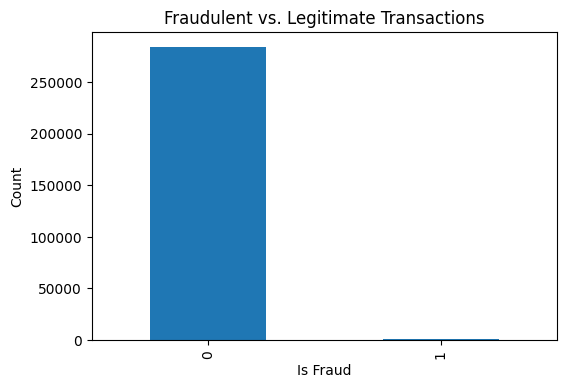

In [33]:
#Exploratory Data Analysis
plt.figure(figsize=(6,4))
data['is_fraud'].value_counts().plot(kind='bar')
plt.title('Fraudulent vs. Legitimate Transactions')
plt.xlabel('Is Fraud')
plt.ylabel('Count')
plt.show()



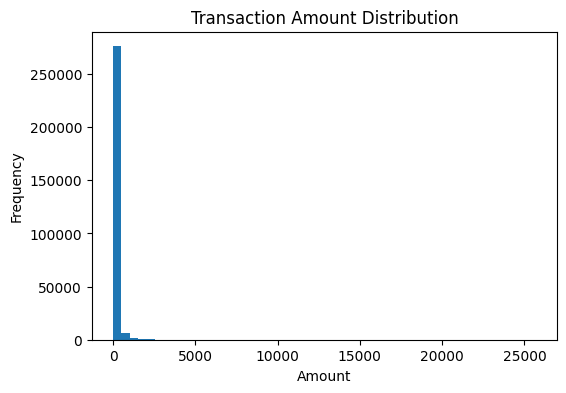

In [34]:
plt.figure(figsize=(6,4))
plt.hist(data['Amount'], bins=50)
plt.title('Transaction Amount Distribution')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.show()

In [ ]:
#Feature Engineering

data['hour'] = ((data['Time'] // 3600) % 24).astype(int)

data['amount_log'] = np.log1p(data['Amount'])
data['amount_zscore'] = (data['Amount'] - data['Amount'].mean()) / data['Amount'].std()

data['time_diff'] = data['Time'].diff().fillna(0)
data['time_diff'] = np.clip(data['time_diff'], 0, data['time_diff'].quantile(0.99))

data['amt_bin'] = pd.qcut(data['Amount'], 4, labels=False)
data['amt_bin'] = data['amt_bin'].fillna(0).astype(int)

data.drop(columns=['Time'], inplace=True)

In [ ]:
#Prepare Features and Labels
drop_cols = ['is_fraud', 'Amount']
X = data.drop(columns=drop_cols)
y = data['is_fraud']

#Drop
mask = y.notna()
X = X[mask]
y = y[mask]

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = ['amt_bin', 'hour']
for c in cat_features:
    if c in numeric_features:
        numeric_features.remove(c)


In [ ]:
#Preprocessing Pipelines
numeric_transformer = Pipeline([('scaler', StandardScaler())])
cat_transformer = Pipeline([('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', cat_transformer, cat_features)
])


In [ ]:
#Handling Class Imbalance and Model Pipeline
sampling_strategy = 0.5
undersampler = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
over_sampler = SMOTE(sampling_strategy=sampling_strategy, random_state=42)

def build_pipeline(sampler):
    return ImbPipeline([
        ('preprocess', preprocessor),
        ('sampling', sampler),
        ('clf', RandomForestClassifier(n_estimators=100, random_state=42))
    ])

pipelines = {
    'undersampling': build_pipeline(undersampler),
    'oversampling': build_pipeline(over_sampler)
}

In [ ]:
#Train-Test Split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [ ]:
#Train and Evaluate Models
for name, pipeline in pipelines.items():
    print(f"\n--- {name.upper()} MODEL ---")
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]
    print(classification_report(y_test, y_pred))
    print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")


--- UNDERSAMPLING MODEL ---
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.08      0.89      0.14        98

    accuracy                           0.98     56962
   macro avg       0.54      0.93      0.57     56962
weighted avg       1.00      0.98      0.99     56962

ROC AUC: 0.9734

--- OVERSAMPLING MODEL ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.90      0.85      0.87        98

    accuracy                           1.00     56962
   macro avg       0.95      0.92      0.94     56962
weighted avg       1.00      1.00      1.00     56962

ROC AUC: 0.9748


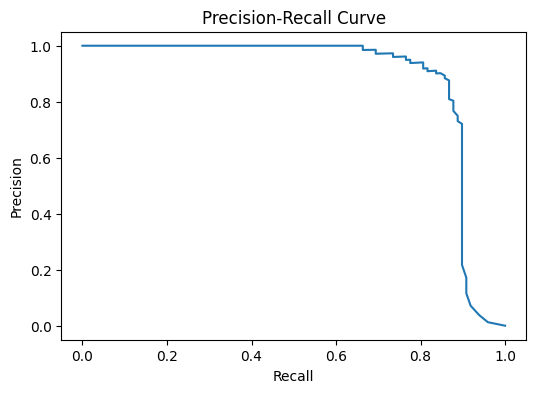

In [ ]:
#Precision-Recall Curve for Best Model (choose based on ROC AUC)
best = pipelines['oversampling']
probs = best.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, probs)
plt.figure(figsize=(6,4))
plt.plot(recall, precision)
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()